In [1]:

import torch
import numpy as np
%load_ext autoreload
%autoreload 2
from utils import load_data,default_loader,trainset,imshow,normal,layershow
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
from torchsummary import summary
import datetime

**Data Path**

In [2]:
datapath = "/home/tete/data/Youtube"
data,paths,labels = load_data(datapath)
available_field = ['url','videoname','locs','frameids','label_names','crop','scale','origRes','isYouTubeSubset']


**shift the data**

In [3]:
num_data=len(paths)
index=np.arange(num_data)
np.random.shuffle(index)
paths=[paths[i] for i in index]
labels=[labels[i] for i in index]

**partition of the data into three part**

In [4]:
#how many data we will put into each set
train_num,val_num, test_num  = int(0.50*num_data),int(num_data*0.30),int(num_data*0.2)

assert(train_num+val_num+test_num<=num_data)
train_path,train_label=paths[0:train_num],labels[0:train_num]
val_path,  val_label  =paths[train_num:train_num+val_num],labels[train_num:train_num+val_num]
test_path, test_label =paths[train_num+val_num:],labels[train_num+val_num:]

train_data  = trainset(train_path,train_label)
trainloader = DataLoader(train_data, batch_size=4,shuffle=True)

val_data  = trainset(val_path,val_label)
valloader = DataLoader(val_data, batch_size=4,shuffle=True)

test_data  = trainset(test_path,test_label)
testloader = DataLoader(test_data, batch_size=4,shuffle=True)
print("number of data in the training set    :", len(train_data))
print("number of data in the validation set  :", len(val_data))
print("number of data in the test set        :", len(test_data))

number of data in the training set    : 2500
number of data in the validation set  : 1500
number of data in the test set        : 1000


**load example data from test set**

In [5]:
count = 1
for data in testloader:
    if count == 1:
        inputs_try,labels_try = data
    count +=1
print(count,"batches")   
print(inputs_try.shape)

251 batches
torch.Size([4, 3, 180, 320])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


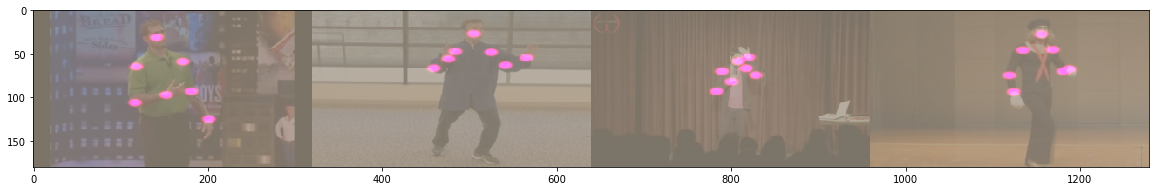

In [6]:
out = torchvision.utils.make_grid(inputs_try,padding=0)
imshow(out,labels_try) 

In [7]:
use_gpu=torch.cuda.is_available()
use_gpu

True

In [23]:
class ConvolutionalAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvolutionalAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=1, padding=1), 
            nn.ReLU(True),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, stride=2),  
            
            nn.Conv2d(32, 64, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, stride=2), 
            
            nn.Conv2d(128, 256, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),  
            nn.MaxPool2d(2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(256, 256, 3, stride=1, padding=1), 
            nn.ReLU(True),
            nn.BatchNorm2d(256),
            nn.Conv2d(256,128, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.BatchNorm2d(128),
            nn.Upsample(size=(45,80),mode='bilinear'),
            
            nn.Conv2d(128, 128, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.BatchNorm2d(128),
            nn.Upsample(size=(90,160) ,mode='bilinear'), 
            
            nn.Conv2d(128, 128, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.BatchNorm2d(128),
            nn.Upsample(size=(180,320) ,mode='bilinear'), 
            
            
        )
        self.conv1=nn.Conv2d(128,128,3,stride=1,padding=1)
        self.conv2=nn.Conv2d(128,7,3,stride=1,padding=1)
        self.soft =nn.Softmax2d()
        
    def forward(self, x):
        x = self.encoder(x)
        x =self.decoder(x)
        x =self.conv1(x)
        x =self.conv2(x)
        x =self.soft(x)
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
model = ConvolutionalAutoEncoder().to(device)
summary(model, (3, 180, 320))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 180, 320]             448
              ReLU-2         [-1, 16, 180, 320]               0
       BatchNorm2d-3         [-1, 16, 180, 320]              32
            Conv2d-4         [-1, 32, 180, 320]           4,640
              ReLU-5         [-1, 32, 180, 320]               0
       BatchNorm2d-6         [-1, 32, 180, 320]              64
         MaxPool2d-7          [-1, 32, 90, 160]               0
            Conv2d-8          [-1, 64, 90, 160]          18,496
              ReLU-9          [-1, 64, 90, 160]               0
      BatchNorm2d-10          [-1, 64, 90, 160]             128
           Conv2d-11         [-1, 128, 90, 160]          73,856
             ReLU-12         [-1, 128, 90, 160]               0
      BatchNorm2d-13         [-1, 128, 90, 160]             256
        MaxPool2d-14          [-1, 128,

In [24]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3,stride=1,padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3,stride=1,padding=1)
        self.conv4 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3,stride=1,padding=1)
        self.conv5 = nn.Conv2d(32, 64, kernel_size=3,stride=1,padding=1)
        self.conv6 = nn.Conv2d(64, 7, kernel_size=3,stride=1,padding=1)
        self.softmax =nn.Softmax2d()
        if use_gpu:
            self.conv1=self.conv1.cuda()
            self.conv2=self.conv2.cuda()
            self.conv3=self.conv3.cuda()
            self.softmax=self.softmax.cuda()
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        #print(x.shape)
        return self.softmax(x)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
model = Net().to(device)
summary(model, (3, 180, 320))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 180, 320]             896
            Conv2d-2         [-1, 64, 180, 320]          18,496
            Conv2d-3        [-1, 128, 180, 320]          73,856
         Softmax2d-4        [-1, 128, 180, 320]               0
Total params: 93,248
Trainable params: 93,248
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.66
Forward/backward pass size (MB): 154.69
Params size (MB): 0.36
Estimated Total Size (MB): 155.70
----------------------------------------------------------------


In [25]:
def train(model,trainloader,loss_fn,optimizer):
    if use_gpu:
        model=model.to("cuda")
        
    model.train(True)
    optimizer = optimizer

    running_corrects = 0.0
    running_loss = 0.0
    size = 0
    for data in trainloader:
        inputs, labels = data
        bs = labels.size(0)

        if use_gpu:
            inputs=inputs.cuda()
            labels=labels.cuda()


        outputs = model(inputs)
        #print(outputs.shape, labels.shape)
        loss = loss_fn(outputs,labels) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds=outputs.data
        # statistics
        running_loss += loss.data.item()
        size += bs
              
            
    epoch_loss = running_loss / size      
    return epoch_loss


def test(model,data_loader,loss_fn,optimizer):
    model.eval()
    if use_gpu:
        model=model.to("cuda")
    running_corrects = 0.0
    running_loss = 0.0
    size = 0
    with torch.no_grad():

        for data in data_loader:
            inputs, labels = data    
            bs = labels.size(0)

            if use_gpu:
                inputs=inputs.cuda()
                labels=labels.cuda()

            outputs = model(inputs)
            loss = loss_fn(outputs,labels) 

            #running_loss+=loss.data.item()
            #_,preds = torch.max(outputs.data,1)
            # statistics
            running_loss += loss.data.item()
            #running_corrects += torch.sum(preds == labels)
            size += bs
            
        epoch_loss = running_loss / size
    return epoch_loss

In [26]:
pose_detection = ConvolutionalAutoEncoder()
# choose the appropriate loss
loss_fn = nn.MSELoss(reduction='sum')
#loss_fn = nn.MSELoss(reduction='sum')
learning_rate = 1.0
# your SGD optimizer
#optimizer_cl = torch.optim.Adadelta(pose_detection.parameters(),lr = learning_rate)
optimizer = torch.optim.Adadelta(pose_detection.parameters(),lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
# and train for 10 epochs
l_t,l_v=[],[]

In [27]:
num_epoch=20

time_begin=time.time()

for epoch in range(num_epoch):
    scheduler.step()
    epoch_loss=train(pose_detection,trainloader,loss_fn,optimizer)
    val_loss  =test(pose_detection,valloader,loss_fn,optimizer)
    print('Epoch:',epoch+1, ' Train - Loss: {:.2f} ; Validation - Loss: {:.2f}'.format(epoch_loss,val_loss))
    l_t.append(epoch_loss)
    l_v.append(val_loss)
    now=time.time()
    time_used=now-time_begin
    time_remain= time_used /(epoch+1) *(num_epoch-1-epoch)
    print("Time consumed:", datetime.timedelta(seconds=time_used), "Remaining time:", datetime.timedelta(seconds=time_remain))

Epoch: 1  Train - Loss: 21106.93 ; Validation - Loss: 55991.23
Time consumed: 0:08:14.799110 Remaining time: 2:36:41.183089
Epoch: 2  Train - Loss: 18958.89 ; Validation - Loss: 8414.67
Time consumed: 0:14:38.447750 Remaining time: 2:11:46.029753
Epoch: 3  Train - Loss: 12403.88 ; Validation - Loss: 8308.78
Time consumed: 0:21:02.810684 Remaining time: 1:59:15.927212
Epoch: 4  Train - Loss: 8299.10 ; Validation - Loss: 8517.98
Time consumed: 0:27:25.027230 Remaining time: 1:49:40.108919
Epoch: 5  Train - Loss: 8310.23 ; Validation - Loss: 8311.42
Time consumed: 0:33:47.544499 Remaining time: 1:41:22.633497
Epoch: 6  Train - Loss: 8281.89 ; Validation - Loss: 8301.12
Time consumed: 0:40:11.750049 Remaining time: 1:33:47.416781
Epoch: 7  Train - Loss: 8287.25 ; Validation - Loss: 8290.89
Time consumed: 0:46:36.568259 Remaining time: 1:26:33.626768
Epoch: 8  Train - Loss: 8327.19 ; Validation - Loss: 8286.41
Time consumed: 0:52:59.898572 Remaining time: 1:19:29.847858
Epoch: 9  Train - Lo

KeyboardInterrupt: 

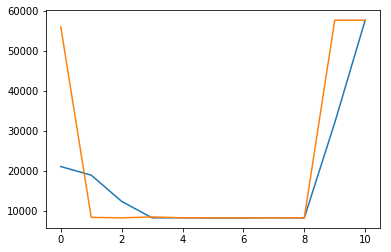

In [28]:
plt.plot(range(len(l_t)),l_t,l_v)

In [29]:
preds.shape ,labels_try.shape

(torch.Size([4, 7, 180, 320]), torch.Size([4, 7, 180, 320]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


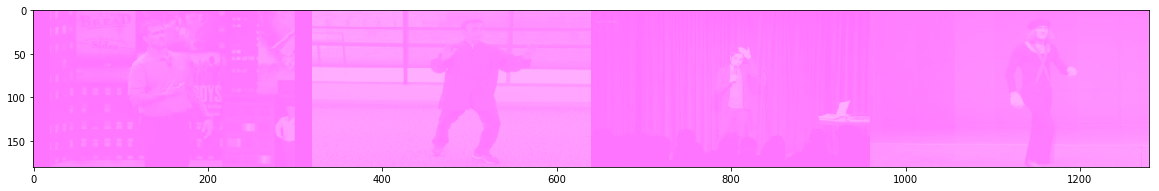

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


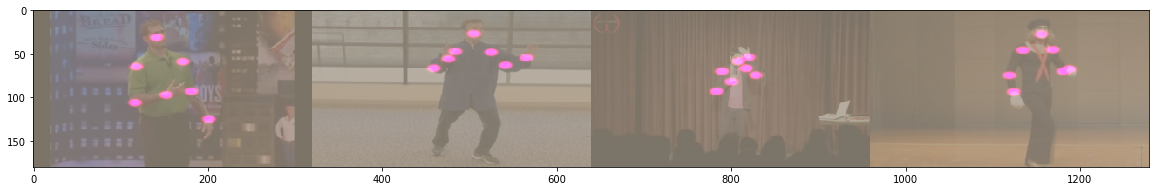

In [30]:
with torch.no_grad():
    preds=pose_detection(inputs_try.cuda()).cpu()
out = torchvision.utils.make_grid(inputs_try,padding=0)
imshow(out,preds) 
imshow(out,labels_try) 